# Derive models of drone

Do all imports.

In [1]:
import sympy as sym
from sympy import *
import numpy as np
from scipy import linalg
import random
init_printing(use_unicode=True)

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Dynamic model

Define physical parameters.

In [2]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

Derive the equations of motion:

In [3]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world * v_in_body,
    M * w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() * (tau_in_body - w_in_body.cross(J * w_in_body)),
)

f = sym.simplify(f, full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{p}_x \\ \dot{p}_y \\ \dot{p}_z \\ \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{v}_x \\ \dot{v}_y \\ \dot{v}_z \\ \dot{w}_x \\ \dot{w}_y \\ \dot{w}_z \end{bmatrix} = f\left(p_x, p_y, p_z, \psi, \theta, \phi, v_x, v_y, v_z, w_x, w_y, w_z, \tau_x, \tau_y, \tau_z, f_z \right)$$

Here is the function $f$:

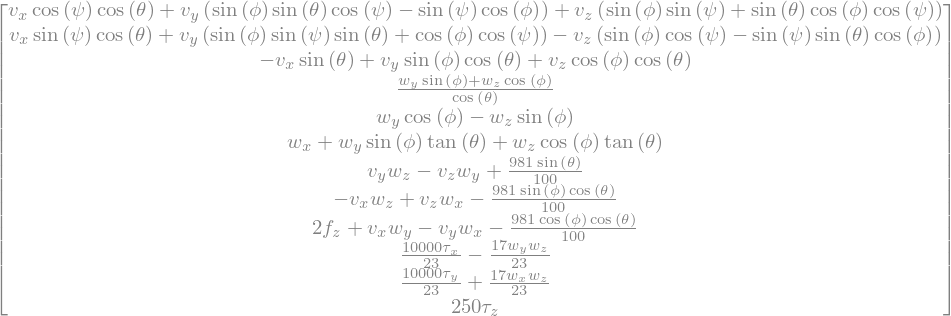

In [4]:
f
# print(latex(f))

## Dynamic model linearization ##
Equilibrium points

In [5]:
gravity = 9.81

px_e = 0.
py_e = 0.
pz_e = 0.
psi_e =0.
theta_e = 0.
phi_e = 0.
vx_e = 0.
vy_e = 0.
vz_e = 0.
wx_e = 0.
wy_e = 0.
wz_e = 0.
taux_e = 0. # not 0
tauy_e = 0.
tauz_e = 0.
fz_e = gravity / 2.

In [6]:
f_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), f)

# verify equilibrium point
if not np.allclose(f_num(px_e, py_e, pz_e, psi_e, theta_e, phi_e, vx_e, vy_e, 
                     vz_e, wx_e, wy_e, wz_e, taux_e, tauy_e, tauz_e, fz_e), 0.):
    raise Exception('equilibrium point is invalid')

In [7]:
# Derive A & B matrices
A_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), 
                     f.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))
A = A_num(px_e, py_e, pz_e, psi_e, theta_e, phi_e, vx_e, vy_e, 
                     vz_e, wx_e, wy_e, wz_e, taux_e, tauy_e, tauz_e, fz_e)

B_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), 
                     f.jacobian([tau_x, tau_y, tau_z, f_z]))
B = B_num(px_e, py_e, pz_e, psi_e, theta_e, phi_e, vx_e, vy_e, 
                     vz_e, wx_e, wy_e, wz_e, taux_e, tauy_e, tauz_e, fz_e)
print('A: \n', A)
print('\n B: \n', B)

A: 
 [[ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.    0.   -0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.   -0.    0.    0.    0.    0.    1.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.   -0.    0.   -0.    0.  ]
 [ 0.    0.    0.    0.    0.   -9.81 -0.    0.    0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.    0.   -0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

 B: 
 [[  0.          0.          0.          0.       ]
 [  0.          0.          0.      

### Controller Design ###

LQR definition

In [8]:
# define lqr optimization function

def lqr(a, b, q, r):
    P = linalg.solve_continuous_are(a, b, q, r)
    return linalg.inv(r) @ b.T @ P

Controllability

In [9]:
# controllability

# defining W = [B, AB, (A^2)B, ... (A^n-1)B]
W_c = B
for i in range(1, A.shape[0]):
    col_c = np.linalg.matrix_power(A, i) @ B
    W_c = np.block([W_c, col_c])

# compare the rank of W to the size of A;
print(np.linalg.matrix_rank(W_c))
if not np.allclose(np.linalg.matrix_rank(W_c), A.shape[0]):
    raise Exception('System is not controllable (not full rank)')

12


In [10]:
# p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z

Qc = np.eye(12)
Rc = np.diag([20., 20., 20., .5])

K = lqr(A, B, Qc, Rc)
print('K: \n', K)

# verify all eigvals have negative real parts
F = A - B @ K
s = linalg.eigvals(F)
if not (((s.real < 0).all())):
    raise Exception('eigval real parts are not all negative ')

K: 
 [[-0.         -0.2236068   0.          0.          0.          1.24651858
  -0.         -0.326842   -0.          0.23608046 -0.          0.        ]
 [ 0.2236068   0.         -0.         -0.          1.24651858 -0.
   0.326842    0.         -0.         -0.          0.23608046  0.        ]
 [-0.          0.         -0.          0.2236068   0.         -0.
   0.          0.          0.          0.          0.          0.22757165]
 [-0.          0.          1.41421356 -0.         -0.         -0.
  -0.          0.          1.84775907 -0.         -0.          0.        ]]


## Sensor model

Define the sensor model.

In [11]:
g = sym.Matrix([p_x, p_y, p_z, psi])

The sensor model has this form:

$$o = g(p_x, p_y, p_z, \psi)$$

Here is the function $g$:

In [12]:
g
print(latex(g))

\left[\begin{matrix}p_{x}\\p_{y}\\p_{z}\\\psi\end{matrix}\right]


## Sensor model linearization ##

In [13]:
g_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), g)
C_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), 
                     g.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))
C = C_num(px_e, py_e, pz_e, psi_e, theta_e, phi_e, vx_e, vy_e, vz_e, wx_e, wy_e, wz_e, taux_e, tauy_e, tauz_e, fz_e)
print('C: \n', C)

g_e = g_num(px_e, py_e, pz_e, psi_e, theta_e, phi_e, vx_e, vy_e, 
                     vz_e, wx_e, wy_e, wz_e, taux_e, tauy_e, tauz_e, fz_e)
# C = sym.Matrix(C)
# print(latex(C))

C: 
 [[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]]


Observability

In [14]:
W_o = C.transpose()
for i in range(1, A.shape[0]):
    col_o = np.linalg.matrix_power(A.transpose(), i) @ C.transpose()
    W_o = np.block([W_o, col_o])

# compare the rank of W to the size of A;
if not np.allclose(np.linalg.matrix_rank(W_o), A.shape[0]):
    raise Exception('System is not observable (not full rank)')
    
print(W_o.shape)

(12, 48)


In [15]:
Qo = Rc
Ro = np.eye(12)

L = lqr(A.T, C.T, np.linalg.inv(Ro), np.linalg.inv(Qo)).T
print('L: \n', L)

# verify all eigvals have negative real parts
F = A - L @ C
s = linalg.eigvals(F)
if not (((s.real < 0).all())):
    raise Exception('eigval real parts are not all negative ')

L: 
 [[ 9.60084014  0.          0.          0.        ]
 [ 0.          9.60084014  0.          0.        ]
 [ 0.          0.          5.3799881   0.        ]
 [ 0.          0.          0.          1.38355107]
 [ 7.27346617  0.          0.          0.        ]
 [ 0.         -7.27346617  0.          0.        ]
 [36.08806568  0.          0.          0.        ]
 [ 0.         36.08806568  0.          0.        ]
 [ 0.          0.          4.47213595  0.        ]
 [ 0.         -4.47213595  0.          0.        ]
 [ 4.47213595  0.          0.          0.        ]
 [ 0.          0.          0.          0.70710678]]


# Quadrotor (aka "the drone")

## Example of how to set everything up (do this only once)

Import modules.

In [16]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

pybullet build time: Jan 28 2022 20:18:15


Create and print a seed for the random number generator so it is possible to reproduce the results.

In [17]:
seed = secrets.randbits(32)
print(seed)

4027441439


Create simulator with seed. Restart kernel if you need to run this again.

In [18]:
simulator = ae353_drone.Simulator(
    display=False,
    seed= seed,
)

## Example of how to add a drone and run a simulation

Define a controller for the drone.

In [73]:
class Controller:
    def __init__(self):
        self.variables_to_log = ['xhat', 'p_des', 'p_hat', 'y']
        self.K = K
        self.A = A
        self.B = B
        self.C = C
        self.L = L
        self.dt = 0.01

    def get_color(self):
        return [1., 0., 0.]

    def reset(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
        ):
        
        self.xhat = np.array([p_x_meas, p_y_meas, p_z_meas, yaw_meas, theta_e, phi_e, vx_e, vy_e, 
                              vz_e, wx_e, wy_e, wz_e])

    def run(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
            p_x_ring, p_y_ring, p_z_ring, # <-- center position of next ring (meters)
            is_last_ring,                 # <-- True if next ring is the last ring, False otherwise
            pos_others,                   # <-- 2d array of size n x 3, where n is the number
                                          #     of all *other* drones - the ith row in this array
                                          #     has the coordinates [x_i, y_i, z_i], in meters, of
                                          #     the ith other drone
        ):
        
        # distance between p_hat and p_des
        r = 2.
        
        # calculate desired position
        p_ring = np.array([p_x_ring, p_y_ring, p_z_ring, 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        self.p_hat = np.array([p_x_meas, p_y_meas, p_z_meas, yaw_meas, 0., 0., 0., 0., 0., 0., 0., 0.])
        
        p_sub = p_ring - self.p_hat
        
        self.p_des = self.p_hat + r * ((p_sub) / np.linalg.norm(p_sub))
        
        # state calcs
        u = -K @ (self.xhat - self.p_des)
        
        self.y = np.array([p_x_meas, p_y_meas, p_z_meas, yaw_meas])
        
        self.xhat += self.dt * (A @ self.xhat + B @ u - L @ (C @ self.xhat - self.y))
        
        tau_x = u[0] + taux_e
        tau_y = u[1] + tauy_e
        tau_z = u[2] + tauz_e
        f_z = u[3] + fz_e

        return tau_x, tau_y, tau_z, f_z

Add the drone to the simulator. There are three arguments:

* `Controller` is the class definition
* `'my_netid'` is the name of the drone
* `'my_image.png'` is the name of an image to use as a label (can be `None`, can be a file path)

You can call this function more than once, so long as you call it with a different drone name each time. An exception will be raised if you try to add two drones of the same name to the simulator.

In [74]:
simulator.clear_drones()

In [75]:
simulator.add_drone(Controller, 'dronedrone', 'my_image.png')

Reset the drone (i.e., place it at a random location in the start ring).

In [76]:
simulator.reset()
simulator.camera_droneview('dronedrone')

Run simulation until `max_time` is reached or until the drone reaches the finish ring.

In [77]:
simulator.run(max_time=60.)

FINISHED: drone "dronedrone" at time 26.93


In [141]:
times = []
runtimes = []
controller_error = []
observer_error = []
success = 0


for i in range (0, 100):
    simulator.reset()
    simulator.run(max_time=60.) 
    
    (
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
    ) = simulator.get_result('dronedrone')
    data = simulator.get_data('dronedrone')
    
    # drone runtime & successful runs
    if (did_it_finish):
        times.append(what_time_did_it_finish)
        success += 1
    
    # controller runtime
    runtimes.append(data['run_time'])
    
    # controller and observer error
    actual_pos = data['p_hat'][0:, 0:3]
    des_pos = data['p_des'][0:, 0:3]
    est_pos = data['xhat'][0:, 0:3]
    oerr = []
    cerr = []
    for i in range (0, len(est_pos)):
        act_mag = np.linalg.norm(est_pos)
        des_mag = np.linalg.norm(des_pos)
        est_mag = np.linalg.norm(actual_pos)
        oerr.append(abs(est_mag - des_mag) / des_mag)
        cerr.append(abs(est_mag - act_mag) / act_mag)
    oerr = np.average(oerr)
    cerr = np.average(cerr)
    controller_error.append(cerr)
    observer_error.append(oerr)


print('Successfully completed runs (of 100): ', success)

FINISHED: drone "dronedrone" at time 26.71

error on run of drone dronedrone (turning it off):
Traceback (most recent call last):
  File "/Users/bellawatters/Documents/ae353-sp22/projects/04_drone/ae353_drone.py", line 791, in step
    raise Exception(f'Run timeout exceeded: {controller_run_time} > {self.max_controller_run_time}')
Exception: Run timeout exceeded: 0.15348100662231445 > 0.005

FINISHED: drone "dronedrone" at time 26.70
FINISHED: drone "dronedrone" at time 26.65
FINISHED: drone "dronedrone" at time 26.64
FINISHED: drone "dronedrone" at time 26.32
FINISHED: drone "dronedrone" at time 26.23

error on run of drone dronedrone (turning it off):
Traceback (most recent call last):
  File "/Users/bellawatters/Documents/ae353-sp22/projects/04_drone/ae353_drone.py", line 791, in step
    raise Exception(f'Run timeout exceeded: {controller_run_time} > {self.max_controller_run_time}')
Exception: Run timeout exceeded: 0.10037493705749512 > 0.005

FINISHED: drone "dronedrone" at time 2

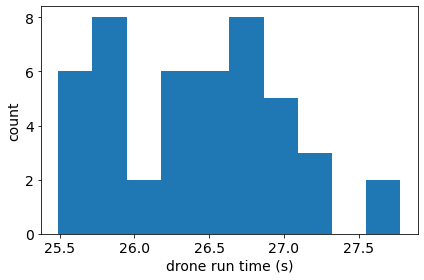

In [146]:
plt.hist(times)
# plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('drone run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.savefig('drone_run_times.png', facecolor='white', transparent=False)
plt.show()


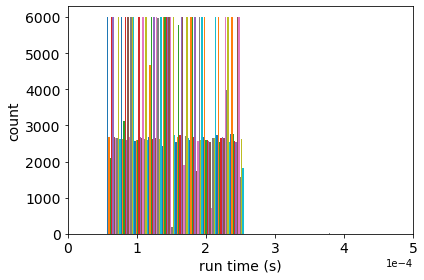

In [147]:
plt.hist(runtimes)
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xlim(0, .0005)
plt.tight_layout()
plt.savefig('controller_run_time.png', facecolor='white', transparent=False)
plt.show()

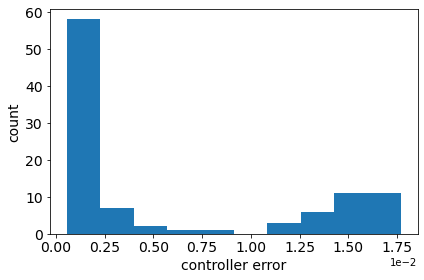

In [151]:
plt.hist(controller_error)
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('controller error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.savefig('controller_error.png', facecolor='white', transparent=False)
plt.show()

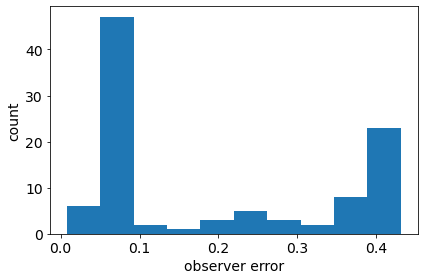

In [150]:
plt.hist(observer_error)
# plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('observer error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.savefig('observer_error.png', facecolor='white', transparent=False)
plt.show()

## Example of how to get and plot results

Assume that we already did two things:

* Added a drone with the name `my_netid` to the simulator
* Ran the simulation

Get result.

In [97]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('dronedrone')

Show result.

In [98]:
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

The drone did not finish (yet).


Get data.

In [134]:
data = simulator.get_data('dronedrone')
est_pos = data['p_hat'][0:, 0:3]
des_pos = data['p_des'][0:, 0:3]
err = []
for i in range (0, len(est_pos)):
    est_mag = np.linalg.norm(est_pos)
    des_mag = np.linalg.norm(des_pos)
    err.append(abs(est_mag - des_mag) / des_mag)
err = np.average(err)

Plot results.

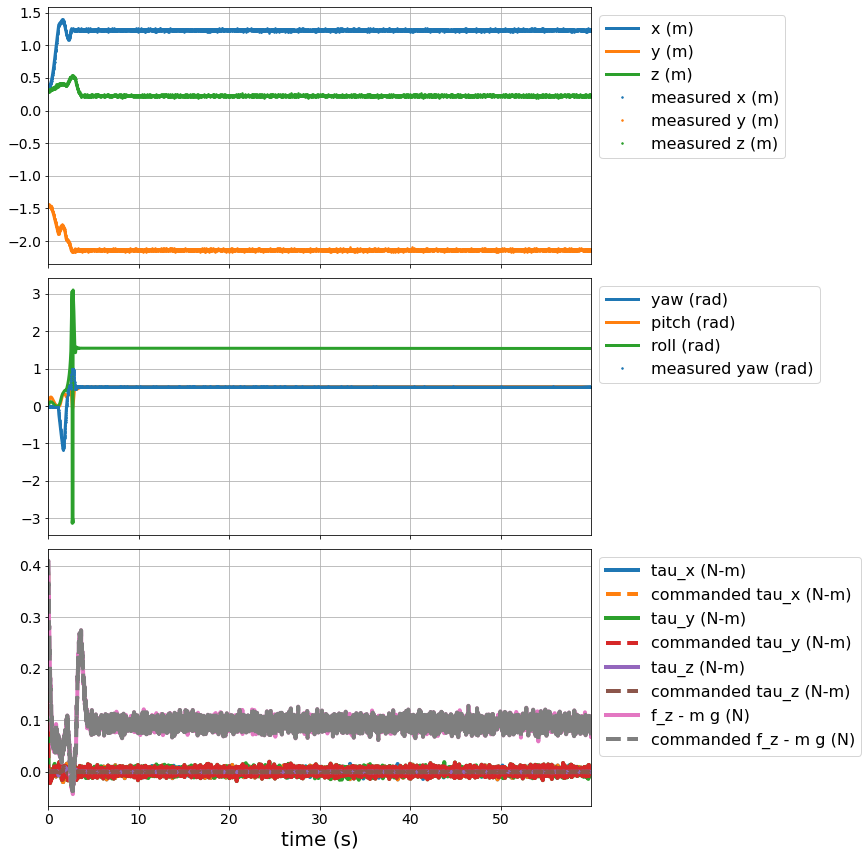

In [106]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_ori, ax_act) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.plot(data['t'], data['p_x_meas'], '.', label='measured x (m)', markersize=3, color='C0')
ax_pos.plot(data['t'], data['p_y_meas'], '.', label='measured y (m)', markersize=3, color='C1')
ax_pos.plot(data['t'], data['p_z_meas'], '.', label='measured z (m)', markersize=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.plot(data['t'], data['yaw_meas'], '.', label='measured yaw (rad)', markersize=3, color='C0')
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)
# ax_act.set_ylim(-10, 10) # <-- FIXME

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

Save the figure (without transparent background).

In [48]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot histogram of controller run times.

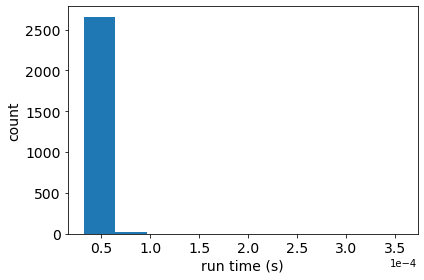

In [49]:
plt.hist(data['run_time'])
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.show()

Note that it is required to also plot state estimates (in comparison to states) in order to check that your observer is working - no example is provided here, since no state estimates are being generated by the template `Controller` class.

## Example of how to load drones from the "students" directory

Load drones from `students` directory.

In [ ]:
failures = simulator.load_drones()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to show results, change views, keep running

Show results (so far).

In [ ]:
simulator.show_results()

View from behind a particular drone (assuming one exists that is named `template`).

In [ ]:
simulator.camera_droneview('my_netid')

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

View from finish ring instead of from start ring.

In [ ]:
simulator.camera_finishview()

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

Show results (so far).

In [ ]:
simulator.show_results()

## Example of how to clear and reload drones

Clear all drones.

In [ ]:
simulator.clear_drones()

Load drones again from `students` directory.

In [ ]:
simulator.load_drones()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to rearrange the rings

Rearrange the rings.

In [ ]:
simulator.move_rings()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to take a snapshot

View from behind a particular drone.

In [ ]:
simulator.camera_droneview('template')

Display a snapshot.

In [ ]:
# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(9, 9))
plt.imshow(rgba)

Save the snapshot.

In [ ]:
plt.imsave('my_snapshot.png', rgba)

## Example of how to record a movie

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

View from behind a particular drone.

In [ ]:
simulator.camera_droneview('template')

Run simulation until `max_time` is reached or until all drones finish, saving movie to `my_video.mp4`.

In [ ]:
simulator.run(max_time=1.0, video_filename='my_video.mp4')

## Example of how to allow print statements and long run times

By default, your controller will fail if either of the following conditions is met:

* It prints something to `stdout`.
* It exceeds the maximum runtime of `1` second for `init`, `1` second for `reset`, and `5e-3` seconds for `run`.

You can relax these rules for the purpose of development if you want, as follows.

In [ ]:
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
)